In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 定義 Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block.
    """
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Squeeze: Global Average Pooling
        self.fc = nn.Sequential(                 # Excitation
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x) # Scale: Channel-wise multiplication

# 定義 Encoder 模塊，包含 Conv -> BN -> ReLU -> SE
class EncoderBlock(nn.Module):
    """
    Encoder block with Conv2d, BatchNorm2d, ReLU, and SEBlock.
    Uses stride=2 for downsampling.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, reduction=16):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(out_channels, reduction=reduction)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.se(x)
        return x

# 定義 U-Net 風格的 Decoder 模塊
# 這個模塊包含 ConvTranspose2d (上採樣), 拼接跳躍連接, 1x1 卷積處理, BN, ReLU, SE
class DecoderBlock(nn.Module):
    """
    Decoder block with ConvTranspose2d, Skip Connection, 1x1 Conv, BatchNorm2d, ReLU, and SEBlock.
    """
    # in_channels: 從前一個 Decoder 模塊或 GRU 接收的輸入通道數 (ConvT 的輸入)
    # convt_out_channels: ConvTranspose2d 的輸出通道數 (反卷積後的通道數)
    # skip_channels: 跳躍連接的通道數
    # final_out_channels: 這個塊的最終輸出通道數 (處理拼接特徵後的通道數，也是下一個 ConvT 的輸入)
    def __init__(self, in_channels, convt_out_channels, skip_channels, final_out_channels, kernel_size=5, stride=2, padding=2, output_padding=1, reduction=16):
        super(DecoderBlock, self).__init__()
        # ConvTranspose2d for upsampling
        self.convt = nn.ConvTranspose2d(in_channels, convt_out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding)

        # 1x1 Conv to process concatenated features and adjust channel count
        # Input channels = ConvT output channels + Skip connection channels
        self.conv1x1 = nn.Conv2d(convt_out_channels + skip_channels, final_out_channels, kernel_size=1)

        # Processing layers after concatenation and 1x1 conv
        self.bn = nn.BatchNorm2d(final_out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(final_out_channels, reduction=reduction)

    def forward(self, x, skip_connection):
        # 1. Perform Transposed Convolution (Upsampling)
        x = self.convt(x) # x shape: (B, convt_out_channels, H_new, W_new)

        # 2. Concatenate with skip connection (assuming H_new, W_new match skip_connection H, W)
        # Add a size check just in case (should ideally match with correct ConvT params)
        if x.shape[-2:] != skip_connection.shape[-2:]:
            # This should ideally not happen if ConvT output_padding/kernel/stride are correctly calculated
            # to exactly reverse the encoder Conv.
            print(f"Warning: Decoder ConvT output shape {x.shape} does not match skip connection shape {skip_connection.shape}. Interpolating skip connection.")
            # Interpolate skip to match ConvT output size before concatenating
            skip_connection = F.interpolate(skip_connection, size=x.shape[-2:], mode='nearest') # Using nearest for features

        x = torch.cat([x, skip_connection], dim=1) # x shape: (B, convt_out_channels + skip_channels, H, W)

        # 3. Process the combined features with 1x1 Conv
        x = self.conv1x1(x) # x shape: (B, final_out_channels, H, W)

        # 4. Apply subsequent processing layers
        x = self.bn(x)
        x = self.relu(x)
        x = self.se(x)

        return x # Return processed features (B, final_out_channels, H, W)


class ComplexCRN(nn.Module):
    """
    Complex Convolutional Recurrent Network (CRN) with SE Blocks and Skip Connections.
    Processes complex-valued audio features (reshaped real/imaginary as channels).
    """
    def __init__(self, input_channels=8, hidden_size=256, num_layers=2, output_channels=2, reduction=16):
        """
        Args:
            input_channels (int): Number of input channels (e.g., 2*num_mics for reshaped complex).
            hidden_size (int): Hidden size of the GRU.
            num_layers (int): Number of layers in the GRU.
            output_channels (int): Number of output channels (e.g., 2 for complex mask).
            reduction (int): Reduction ratio for SE blocks.
        """
        super(ComplexCRN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_channels = output_channels

        # Encoder layers (with SE and preparing for skips)
        # Input (B, 2*C_in, F, T)
        self.enc1 = EncoderBlock(input_channels, 32, reduction=reduction)  # Output: (B, 32, F/2, T/2)
        self.enc2 = EncoderBlock(32, 64, reduction=reduction)      # Output: (B, 64, F/4, T/4)
        self.enc3 = EncoderBlock(64, 128, reduction=reduction)     # Output: (B, 128, F/8, T/8)
        self.enc4 = EncoderBlock(128, 256, reduction=reduction)    # Output: (B, 256, F/16, T/16)
        self.enc5 = EncoderBlock(256, 512, reduction=reduction)    # Output: (B, 512, F/32, T/32) - Bottleneck features

        # GRU layer - operates on flattened spatial dimensions of bottleneck features
        # input_size is the number of channels of the last encoder block
        self.gru = nn.GRU(input_size=512, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, batch_first=True, bidirectional=True)

        # Decoder layers (with SE and handling skips)
        # Using DecoderBlockCorrected: ConvT -> Concat(Skip) -> 1x1 Conv -> BN -> ReLU -> SE
        # The 'final_out_channels' of a block becomes the 'in_channels' of the next block's ConvT

        # dec1: From GRU output (hidden_size*2 = 1024)
        # ConvT input: 1024 -> ConvT output: 256 (@ F/16)
        # Skip: enc4 (256)
        # 1x1 Conv input: 256 (ConvT out) + 256 (skip) = 512 -> 1x1 Conv output: 256 (final_out_channels)
        # Output: (B, 256, F/16, T/16)
        self.dec1 = DecoderBlock(in_channels=self.hidden_size * 2, convt_out_channels=256, skip_channels=256, final_out_channels=256, reduction=reduction)

        # dec2: From dec1 output (256)
        # ConvT input: 256 -> ConvT output: 128 (@ F/8)
        # Skip: enc3 (128)
        # 1x1 Conv input: 128 (ConvT out) + 128 (skip) = 256 -> 1x1 Conv output: 128 (final_out_channels)
        # Output: (B, 128, F/8, T/8)
        self.dec2 = DecoderBlock(in_channels=256, convt_out_channels=128, skip_channels=128, final_out_channels=128, reduction=reduction)

        # dec3: From dec2 output (128)
        # ConvT input: 128 -> ConvT output: 64 (@ F/4)
        # Skip: enc2 (64)
        # 1x1 Conv input: 64 (ConvT out) + 64 (skip) = 128 -> 1x1 Conv output: 64 (final_out_channels)
        # Output: (B, 64, F/4, T/4)
        self.dec3 = DecoderBlock(in_channels=128, convt_out_channels=64, skip_channels=64, final_out_channels=64, reduction=reduction)

        # dec4: From dec3 output (64)
        # ConvT input: 64 -> ConvT output: 32 (@ F/2)
        # Skip: enc1 (32)
        # 1x1 Conv input: 32 (ConvT out) + 32 (skip) = 64 -> 1x1 Conv output: 32 (final_out_channels)
        # Output: (B, 32, F/2, T/2)
        self.dec4 = DecoderBlock(in_channels=64, convt_out_channels=32, skip_channels=32, final_out_channels=32, reduction=reduction)

        # Final layer: Takes dec4 output (32) and converts to desired output channels (e.g., 2 for mask)
        # No skip connection or SE/BN/ReLU in the final output layer typically.
        # Input channels: final_out_channels of dec4 (32)
        self.final_convt = nn.ConvTranspose2d(32, output_channels, kernel_size=5, stride=2, padding=2, output_padding=1)


    def forward(self, x):
        """
        Forward pass of the ComplexCRN.

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, F, T, 2) for complex data.

        Returns:
            torch.Tensor: Output tensor of shape (B, F, T, output_channels).
        """
        B, C, F, T, complex_dim = x.shape
        assert complex_dim == 2, "Input tensor must have complex dimension 2 (real, imag)"

        # Reshape complex input: Combine real and imaginary into channel dimension
        # From (B, C, F, T, 2) to (B, 2*C, F, T)
        x = x.permute(0, 4, 1, 2, 3).reshape(B, 2 * C, F, T)

        # --- Encoder ---
        e1 = self.enc1(x) # (B, 32, F/2, T/2)
        e2 = self.enc2(e1) # (B, 64, F/4, T/4)
        e3 = self.enc3(e2) # (B, 128, F/8, T/8)
        e4 = self.enc4(e3) # (B, 256, F/16, T/16)
        e5 = self.enc5(e4) # (B, 512, F/32, T/32) - Bottleneck features

        # --- GRU Processing ---
        B_enc, C_enc, F_enc, T_enc = e5.shape
        # Reshape for GRU: Flatten spatial dimensions (F_enc * T_enc) into sequence length
        # From (B, C_enc, F_enc, T_enc) to (B, F_enc * T_enc, C_enc)
        enc_reshaped = e5.view(B_enc, C_enc, F_enc * T_enc).permute(0, 2, 1)

        # Pass through GRU
        rnn_out, _ = self.gru(enc_reshaped) # (B, F_enc * T_enc, hidden_size * 2)

        # Reshape GRU output back to 4D: Restore spatial dimensions, GRU output depth becomes channels
        # From (B, F_enc * T_enc, hidden_size * 2) to (B, hidden_size * 2, F_enc, T_enc)
        rnn_out = rnn_out.permute(0, 2, 1).view(B_enc, self.hidden_size * 2, F_enc, T_enc) # (B, 1024, F/32, T/32)

        # --- Decoder with Skip Connections ---
        # Each decoder block takes the output from the *previous* decoder block
        # and the corresponding skip connection from the encoder.

        # dec1 takes GRU output (rnn_out) and skip e4
        # rnn_out is (B, 1024, F/32, T/32), e4 is (B, 256, F/16, T/16)
        # The first DecoderBlock's ConvT should take rnn_out as input (1024 channels)
        # It outputs 256 channels @ F/16, T/16, then concatenates with e4 (256 @ F/16, T/16)
        # Then the 1x1 Conv reduces 256+256=512 to 256 channels @ F/16, T/16
        d1_out = self.dec1(rnn_out, e4) # Output: (B, 256, F/16, T/16)

        # dec2 takes dec1_out (256 @ F/16, T/16) and skip e3 (128 @ F/8, T/8)
        # ConvT takes 256 -> 128 @ F/8, T/8. Concat with e3 (128). 1x1 Conv 128+128=256 -> 128 @ F/8, T/8
        d2_out = self.dec2(d1_out, e3) # Output: (B, 128, F/8, T/8)

        # dec3 takes dec2_out (128 @ F/8, T/8) and skip e2 (64 @ F/4, T/4)
        # ConvT takes 128 -> 64 @ F/4, T/4. Concat with e2 (64). 1x1 Conv 64+64=128 -> 64 @ F/4, T/4
        d3_out = self.dec3(d2_out, e2) # Output: (B, 64, F/4, T/4)

        # dec4 takes dec3_out (64 @ F/4, T/4) and skip e1 (32 @ F/2, T/2)
        # ConvT takes 64 -> 32 @ F/2, T/2. Concat with e1 (32). 1x1 Conv 32+32=64 -> 32 @ F/2, T/2
        d4_out = self.dec4(d3_out, e1) # Output: (B, 32, F/2, T/2)

        # Final layer takes dec4_out (32 @ F/2, T/2)
        # Final ConvT takes 32 -> output_channels (@ F, T)
        out = self.final_convt(d4_out) # Output: (B, output_channels, F, T)

        # Reshape output to match common mask format (B, F, T, output_channels)
        # The output_channels here is typically 2 (for real and imaginary mask)
        out = out.permute(0, 2, 3, 1) # (B, F, T, output_channels)

        return out

# --- Test Case ---
if __name__ == '__main__':
    print("Testing ComplexCRN model with SE and Skip Connections...")

    # Test parameters
    batch_size = 2
    input_channels_complex = 4 # e.g., 4 microphones -> 4 channels complex
    frequency_bins = 256
    time_frames = 128
    complex_dim = 2 # Real and Imaginary

    # Input tensor shape: (batch_size, channels, frequency_bins, time_frames, complex_dim)
    # This format is common for complex audio features (magnitude, phase, or real, imag)
    # 4 mics complex -> 4 channels * 2 (real/imag) = 8 input features initially
    input_tensor = torch.randn(batch_size, input_channels_complex, frequency_bins, time_frames, complex_dim)

    # Model initialization
    # input_channels for the model is 2 * input_channels_complex
    # output_channels for the model is typically 2 (for a complex mask real/imaginary)
    model = ComplexCRN(input_channels=input_channels_complex * complex_dim,
                       hidden_size=256, # GRU hidden size
                       num_layers=2, # GRU layers
                       output_channels=complex_dim, # Output 2 channels for mask (real, imag)
                       reduction=16) # SE reduction ratio

    # Move model and input to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_tensor = input_tensor.to(device)

    # Forward pass
    print(f"Input tensor shape: {input_tensor.shape} (on device: {input_tensor.device})")
    print(f"Model is on device: {next(model.parameters()).device}")

    try:
        with torch.no_grad(): # Disable gradient calculation for inference test
            output_tensor = model(input_tensor)

        print("Model forward pass successful.")
        print("Input shape:", input_tensor.shape)
        print("Output shape:", output_tensor.shape)

        # Check if output dimensions match expected (batch_size, frequency_bins, time_frames, output_channels)
        expected_output_shape = (batch_size, frequency_bins, time_frames, complex_dim)
        print("Expected output shape:", expected_output_shape)
        assert output_tensor.shape == expected_output_shape
        print("Output shape matches expected shape.")

    except RuntimeError as e:
        print(f"Runtime Error during forward pass: {e}")
        print("Please check input dimensions and layer definitions.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Testing ComplexCRN model with SE and Skip Connections...
Input tensor shape: torch.Size([2, 4, 256, 128, 2]) (on device: cuda:0)
Model is on device: cuda:0
Model forward pass successful.
Input shape: torch.Size([2, 4, 256, 128, 2])
Output shape: torch.Size([2, 256, 128, 2])
Expected output shape: (2, 256, 128, 2)
Output shape matches expected shape.


In [6]:
import os
import h5py
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class L3DAS_Total_HDF5_Dataset(Dataset):
    def __init__(self, h5_file_path, train=True, val_split=0.2):
        self.h5_file_path = h5_file_path
        self.train = train
        self.val_split = val_split
        self.file = None
        self.x_data = None
        self.y_data = None
        self.indices = None
        self._load_data()
        self._split_data()

    def _load_data(self):
        self.file = h5py.File(self.h5_file_path, 'r')
        if 'x' in self.file and 'y' in self.file:
            self.x_data = self.file['x']
            self.y_data = self.file['y']
            self.total_len = len(self.y_data)
        else:
            raise KeyError(f"'{self.h5_file_path}' 檔案中找不到 'x' 或 'y' dataset。")

    def _split_data(self):
        val_len = int(self.total_len * self.val_split)
        train_len = self.total_len - val_len
        all_indices = list(range(self.total_len))
        train_indices, val_indices = random_split(all_indices, [train_len, val_len], generator=torch.Generator().manual_seed(42)) # 使用固定 seed 以確保可重複性

        if self.train:
            self.indices = sorted(list(train_indices))
        else:
            self.indices = sorted(list(val_indices))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_index = self.indices[idx]
        x = self.x_data[original_index]
        y = self.y_data[original_index]
        return torch.as_tensor(x, dtype=torch.float32), torch.as_tensor(y, dtype=torch.float32)

    def __del__(self):
        if self.file:
            self.file.close()

# --- 使用範例 ---
if __name__ == '__main__':
    h5_file = 'total.h5'  # 您的整合後的 HDF5 檔案名
    val_split_ratio = 0.2

    # 創建訓練集 Dataset
    train_dataset = L3DAS_Total_HDF5_Dataset(h5_file, train=True, val_split=val_split_ratio)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

    # 創建驗證集 Dataset
    val_dataset = L3DAS_Total_HDF5_Dataset(h5_file, train=False, val_split=val_split_ratio)
    val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

    print(f"訓練集大小: {len(train_dataset)} 個樣本")
    print(f"驗證集大小: {len(val_dataset)} 個樣本")

    # 測試載入一個訓練批次
    for i, (batch_x, batch_y) in enumerate(train_dataloader):
        print(f"訓練批次 {i+1} x 的形狀:", batch_x.shape)
        print(f"訓練批次 {i+1} y 的形狀:", batch_y.shape)
        break

    # 測試載入一個驗證批次
    for i, (batch_x, batch_y) in enumerate(val_dataloader):
        print(f"驗證批次 {i+1} x 的形狀:", batch_x.shape)
        print(f"驗證批次 {i+1} y 的形狀:", batch_y.shape)
        break

訓練集大小: 42701 個樣本
驗證集大小: 10675 個樣本
訓練批次 1 x 的形狀: torch.Size([64, 4, 256, 128, 2])
訓練批次 1 y 的形狀: torch.Size([64, 256, 128, 2])
驗證批次 1 x 的形狀: torch.Size([64, 4, 256, 128, 2])
驗證批次 1 y 的形狀: torch.Size([64, 256, 128, 2])


In [3]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 2. 建立模型與設備設定
model = ComplexCRN(input_channels=8).to(device)

  # 計算損失
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. 學習率調整器：每個 epoch 學習率 × 0.95
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)

# 5. 訓練迴圈
num_epochs = 100
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_dataloader:
        xb = xb.to(device)  # (B, 4, F, T, 2)
        yb = yb.to(device)  # (B, F, T, 2)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_dataloader)
    loss_history.append(avg_loss)

    # 調整學習率
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.6f} | LR: {current_lr:.6e}")


cuda
[Epoch 1/100] Loss: 1.233626 | LR: 9.500000e-04
[Epoch 2/100] Loss: 1.230396 | LR: 9.025000e-04


KeyboardInterrupt: 

In [7]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

model = ComplexCRN(input_channels=input_channels_complex * complex_dim,
                       hidden_size=256, # GRU hidden size
                       num_layers=2, # GRU layers
                       output_channels=complex_dim, # Output 2 channels for mask (real, imag)
                       reduction=16) # SE reduction ratio

    # Move model and input to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 計算損失
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. 學習率調整器：每個 epoch 學習率 × 0.95
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)

# 5. 訓練迴圈 (包含驗證)
num_epochs = 100
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    # 訓練階段
    model.train()
    running_loss = 0.0
    for xb, yb in train_dataloader:
        xb = xb.to(device)  # (B, 4, F, T, 2)
        yb = yb.to(device)  # (B, F, T, 2)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataloader)
    train_loss_history.append(avg_loss)

    # 驗證階段
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for vxb, vyb in val_dataloader:
            vxb = vxb.to(device)
            vyb = vyb.to(device)
            voutputs = model(vxb)
            val_loss = criterion(voutputs, vyb)
            running_val_loss += val_loss.item()
    avg_val_loss = running_val_loss / len(val_dataloader)
    val_loss_history.append(avg_val_loss)
    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {avg_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.6e}")

    # 調整學習率
    scheduler.step()

[Epoch 1/100] Train Loss: 1.218460 | Val Loss: 1.193804 | LR: 1.000000e-03


KeyboardInterrupt: 

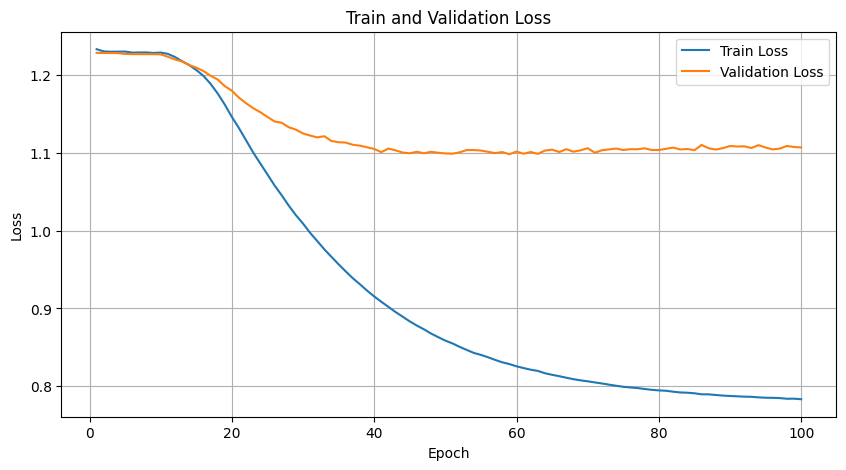

In [8]:
import matplotlib.pyplot as plt

# 假設您的訓練程式碼已經執行完畢，並且 loss_history 列表已經填滿了每個 epoch 的平均損失值

# 繪製訓練損失曲線
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()